In [1]:
'''
학습은 Colab A100 GPU로 했습니다.
모델은 제목과 같이 BEIT-3을 이번 대회 데이터셋에 fine-tuning했습니다.
(원 코드 : https://github.com/microsoft/unilm/tree/master/beit3)
(논문 : https://arxiv.org/abs/2208.10442)

BEIT-3 Github 페이지를 보면 pretrained weight이 있고,
vqav2라고 되어있는 부분에 initialized checkpoint라고 해서 vqav2에 맞게 initialized된 weight가 있습니다.
이번 대회에서는 pretrained 모델 사용 시 vqa 소유 데이터셋이 아닌 데이터로 pretrain된 weight만 사용가능하므로,
홈페이지 첫 부분에 pretrained라고 되어있는 부분에서 base-indomain모델을 다운받고, beit3.spm을 다운받아서, model_path에 넣어줬습니다.

git clone을 구글 드라이브로 한 후, PC용 구글 드라이브를 통해 파일을 수정하고 관리했습니다.
제 git에 있는 코드는 이번 대회에 사용했던, BEiT-3 부분만 이번 대회 데이터셋과 Colab 환경에 맞게 고친 것을 가져온 겁니다.

base-indomain 모델 기준 1 epoch 학습에 약 2시간 10분 정도 소요됐으며, 예측은 8분 ~ 10분 정도 소요됐습니다.
GPU RAM은 256 batch 기준 37GB 소요, 128 batch 기준 22GB 소요됐습니다.
'''

!nvidia-smi

Wed Aug  9 12:32:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    45W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
'''
코랩에서 진행을 하다보니 원래는 구글 드라이브에 해당 이미지 폴더를 만들고 데이터를 옮겨놓은 후에 학습을 하려했습니다.
그런데 이미지가 워낙 많다보니 이미지 불러오는게 시간초과 나서, 압축파일만 구글 드라이브 저장한 후
이미지를 세션에 그냥 임시저장해놓고 학습했습니다. 다른 json파일도 그냥 세션 저장했습니다.
(csv파일만 드라이브에 따로 저장해놨습니다.)
이렇게 하면 이미지를 빠르게 압축 풀고 불러올 수 있긴 한데,
일정 시간이 지나면 세션에 있는 데이터들이 삭제되어서 학습이 진행이 안됩니다.
그래서 아래에도 얘기했지만 1 epoch 씩 학습을 한 후, 런타임을 끊고 다시 시작하면서 학습했습니다.
'''

!unzip -qq '/content/drive/MyDrive/train.zip' -d '/content'
!unzip -qq '/content/drive/MyDrive/test.zip' -d '/content'

In [ ]:
'''
먼저 git code를 클론해주세요. 그리고 해당 디렉토리로 들어가서 필요한 라이브러리를 설치해줍니다. 클론은 1번만 하면 됩니다. 클론하고 주석처리해주세요.
tensorboardX는 학습 시 Nan or Inf found가 warning으로 뜨는게 아닌 그냥 알림으로 뜨도록 하기위해 설치하는데, 안하셔도 무방합니다.
'''

# !git clone https://github.com/microsoft/unilm.git
%cd /content/drive/MyDrive/Dacon_multimodal/github_folder/unilm/beit3
!pip install -r requirements.txt
# !pip install -U tensorboardX

In [6]:
# 필요없는 라이브러리도 있는데, 일단 놔뒀습니다.

import numpy as np
import pandas as pd
import operator
import os
import string
import re
import random
import sys
import platform
import json
import shutil

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

from PIL import Image

from transformers import XLMRobertaTokenizer

from tqdm.auto import tqdm

In [7]:
# 라이브러리 및 device 확인 코드입니다.

has_gpu = torch.cuda.is_available()
has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "cuda" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

Python Platform: Linux-5.15.109+-x86_64-with-glibc2.35
PyTorch Version: 2.0.1+cu118

Python 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
Pandas 1.5.3
GPU is available
MPS (Apple Metal) is NOT AVAILABLE
Target device is cuda


In [8]:
CFG = {
    # 'EPOCHS': 30,
    # 'LEARNING_RATE': 2e-5,
    # 'BATCH_SIZE': 32,
    'SEED': 42,
    # 'MAX_LEN': 16,
}

In [9]:
# run_beit3_finetuning.py 파일 실행할때 seed 넣기는 하는데, 혹시 몰라서 seed 고정 코드도 넣었습니다.

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [10]:
# 파일들을 불러옵니다.

train_df = pd.read_csv('/content/drive/MyDrive/Dacon_multimodal/csv_file/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Dacon_multimodal/csv_file/test.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/Dacon_multimodal/csv_file/sample_submission.csv')
train_img_path = '/content/image_file/train/'
test_img_path = '/content/image_file/test/'

In [11]:
# validation을 위해, train_df를 나눠줍시다.

train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=CFG['SEED'])

# json_file 폴더를 하나 세션에 만듭시다.

os.mkdir('/content/json_file')

In [12]:
# BEIT-3 model을 fine-tuning 할때, json파일이 필요합니다. 아래처럼 json파일을 만들어주세요.

def create_json_data(df, output_filename, id_length):
    data_dicts = []

    for idx, row in df.iterrows():
        data_dict = {'image_id': '', 'question': '', 'question_id': ''}
        image_id = row['image_id']
        # question_id를 만들어줍니다. 이미지 id와 겹치지 않으며, 나중에 sample_submission에 쉽게 넣기위해 앞뒤에 1을 붙이겠습니다.
        question_id = f"{1}{row['ID'][-id_length:]}{1}"

        data_dict['image_id'] = image_id
        data_dict['question'] = row['question']
        data_dict['question_id'] = question_id

        # answer가 존재하는 train, val data의 경우에는 answer도 추가합니다.
        if 'answer' in row:
            data_dict['answer'] = row['answer']

        data_dicts.append(data_dict)

    with open(output_filename, "w") as json_file:
        json.dump(data_dicts, json_file)

# 세션에 저장합니다.
create_json_data(train_df, "/content/json_file/train.json", id_length=6)
create_json_data(val_df, "/content/json_file/val.json", id_length=6)
create_json_data(test_df, "/content/json_file/test.json", id_length=5)

In [ ]:
'''
이번 대회 데이터셋에 맞게, 아래 부분을 수정했습니다.(수정한 코드는 제 git에서 확인해주세요.)
    <수정 내용>
    dataset.py : CustomDataset Class 추가 및 task2dataset에 vqacustom 추가
    utils.py : import torch._six를 torch로 수정(module not found 에러 해결),
                pos_tokens = pos_tokens.float() 코드 추가(575번째 줄, 참고 : https://github.com/microsoft/unilm/issues/932),
                dump_prediction 함수(838번째 줄)에 있는 torch.distributed.barrier() 삭제(single GPU에서의 eval 위함, multi GPU의 경우 삭제 안해도 됨)
    engine_for_finetuning.py : def get_handler 함수에(442번째 줄) args.task == "vqacustom" 추가
    modeling_finetune.py : vqacustom 모델들 추가 및 num_classes부분 수정(label 수에 맞게)
    run_beit3_finetuning.py : parser.add_argument --task 부분에 vqacustom 추가, args.eval(357번째 줄)에 vqacustom 부분(367~370번째 줄) 추가
'''

In [14]:
'''
BEIT-3 모델이 학습하는 형식에 맞게 index를 만드는 코드입니다. 실행해주세요. (폴더는 여러분에게 맞게 바꾸시면 됩니다.)
'''

from datasets import CustomDataset
from transformers import XLMRobertaTokenizer

tokenizer = XLMRobertaTokenizer("/content/drive/MyDrive/Dacon_multimodal/model_file/beit3.spm")

CustomDataset.make_dataset_index(
    data_path="/content/",
    tokenizer=tokenizer,
    json_data_path="/content/json_file/",
)

Write /content/vqa.train.jsonl with 284429 items !
Write /content/vqa.val.jsonl with 50212 items !
Write /content/vqa.test.jsonl with 40479 items !
Contains 37756 image and 50212 pairs for val set!
Write /content/vqa.trainable_val.jsonl with 48882 items !
Write /content/vqa.rest_val.jsonl with 1330 items !


In [ ]:
'''
1. 학습 하이퍼파라미터는 image size를 384로, batch를 256으로 변경하고 나머지는 논문에 나와있는 그대로 하겠습니다.
   384로 하는 이유는 학습하는 데이터의 해상도가 생각보다 작아서, 작은 사이즈로 해줘야할 것 같아서 정했습니다.

2. large model을 파인튜닝하고 싶었으나, large model은 A100 GPU 256 batch 기준 1 epoch당 4시간 30분 ~ 5시간 정도 걸렸습니다.
   세션 시간도 불안하고, 해당 model을 사용한게 대회 종료 2일 전이라 학습 시간도 빠듯해서 base model로 부랴부랴 진행했습니다.
   (모델 문의는 마감 4일 전에 했는데, image를 드라이브에 넣는다고 아주 난리를 피워서 시간이 더 지체됐습니다. 진작에 세션에 넣을걸...)

3. 학습할 때 Nan or Inf found warning이 뜨는 것은 정상입니다!(참고 : https://github.com/microsoft/unilm/issues/1048)

4. 이게 위에서부터 계속 말씀드렸던 문제인데,
   large model 10 epoch 학습 중 1 epoch 학습 이후 세션에 있는 image랑 자료들이 중간에 날아가서 oserror가 발생하는걸 확인했습니다.

5. 그래서 base model로 바꾸고 image와 json, jsonl 파일을 다시 불러온 후,
   주석 처리된 코드로 학습된 checkpoint model을 불러와 2번째 코드로 1 epoch씩 학습했습니다.
   학습할 때 epoch을 하나씩 줄여주면서 했습니다. 그러니까 10으로 epoch을 놓고 1 epoch 학습을 했다면,
   1에폭 종료 후 다시 코랩을 실행한 뒤 다음에는 9로 놓고 1 epoch, 다음에는 8로 놓고 1 epoch 이렇게 줄이면서 했습니다.
   그래서 log.txt보면 epoch이 다 0으로 되어있습니다.(log는 아래 markdown에 이미지로 추가했습니다.)
   주석 처리한 코드는 처음에 실행한 코드, 2번째 코드는 런타임 다시 시작 후 실행한 코드입니다.(2번째 코드를 9번 실행했습니다.)
   ★ 만약에 코드를 참고해서 로컬로 실행해보시는 분이 있다면, 로컬에서는 oserror날 일이 없을 것 같으니 그냥 주석처리된 첫번째 코드 계속 실행하시면 됩니다.

6. 아래 주석 처리된 코드로 warmup epoch 실행 후, 2번째 코드도 batch size 256으로 실행하려고 하니까 out of memory error 나길래
   2번째 코드에서 batch size를 128로 바꿨습니다.
   다시 말해서 첫번째 epoch 때는 batch를 256, 나머지 epoch은 128로 학습했습니다.
   코랩 진짜 한대 치고싶네요... 하

7. validation data에 대한 VQA Score는 base-indomain 모델 fine-tuning결과 10 epochs 기준 75.95%가 나왔습니다.
'''

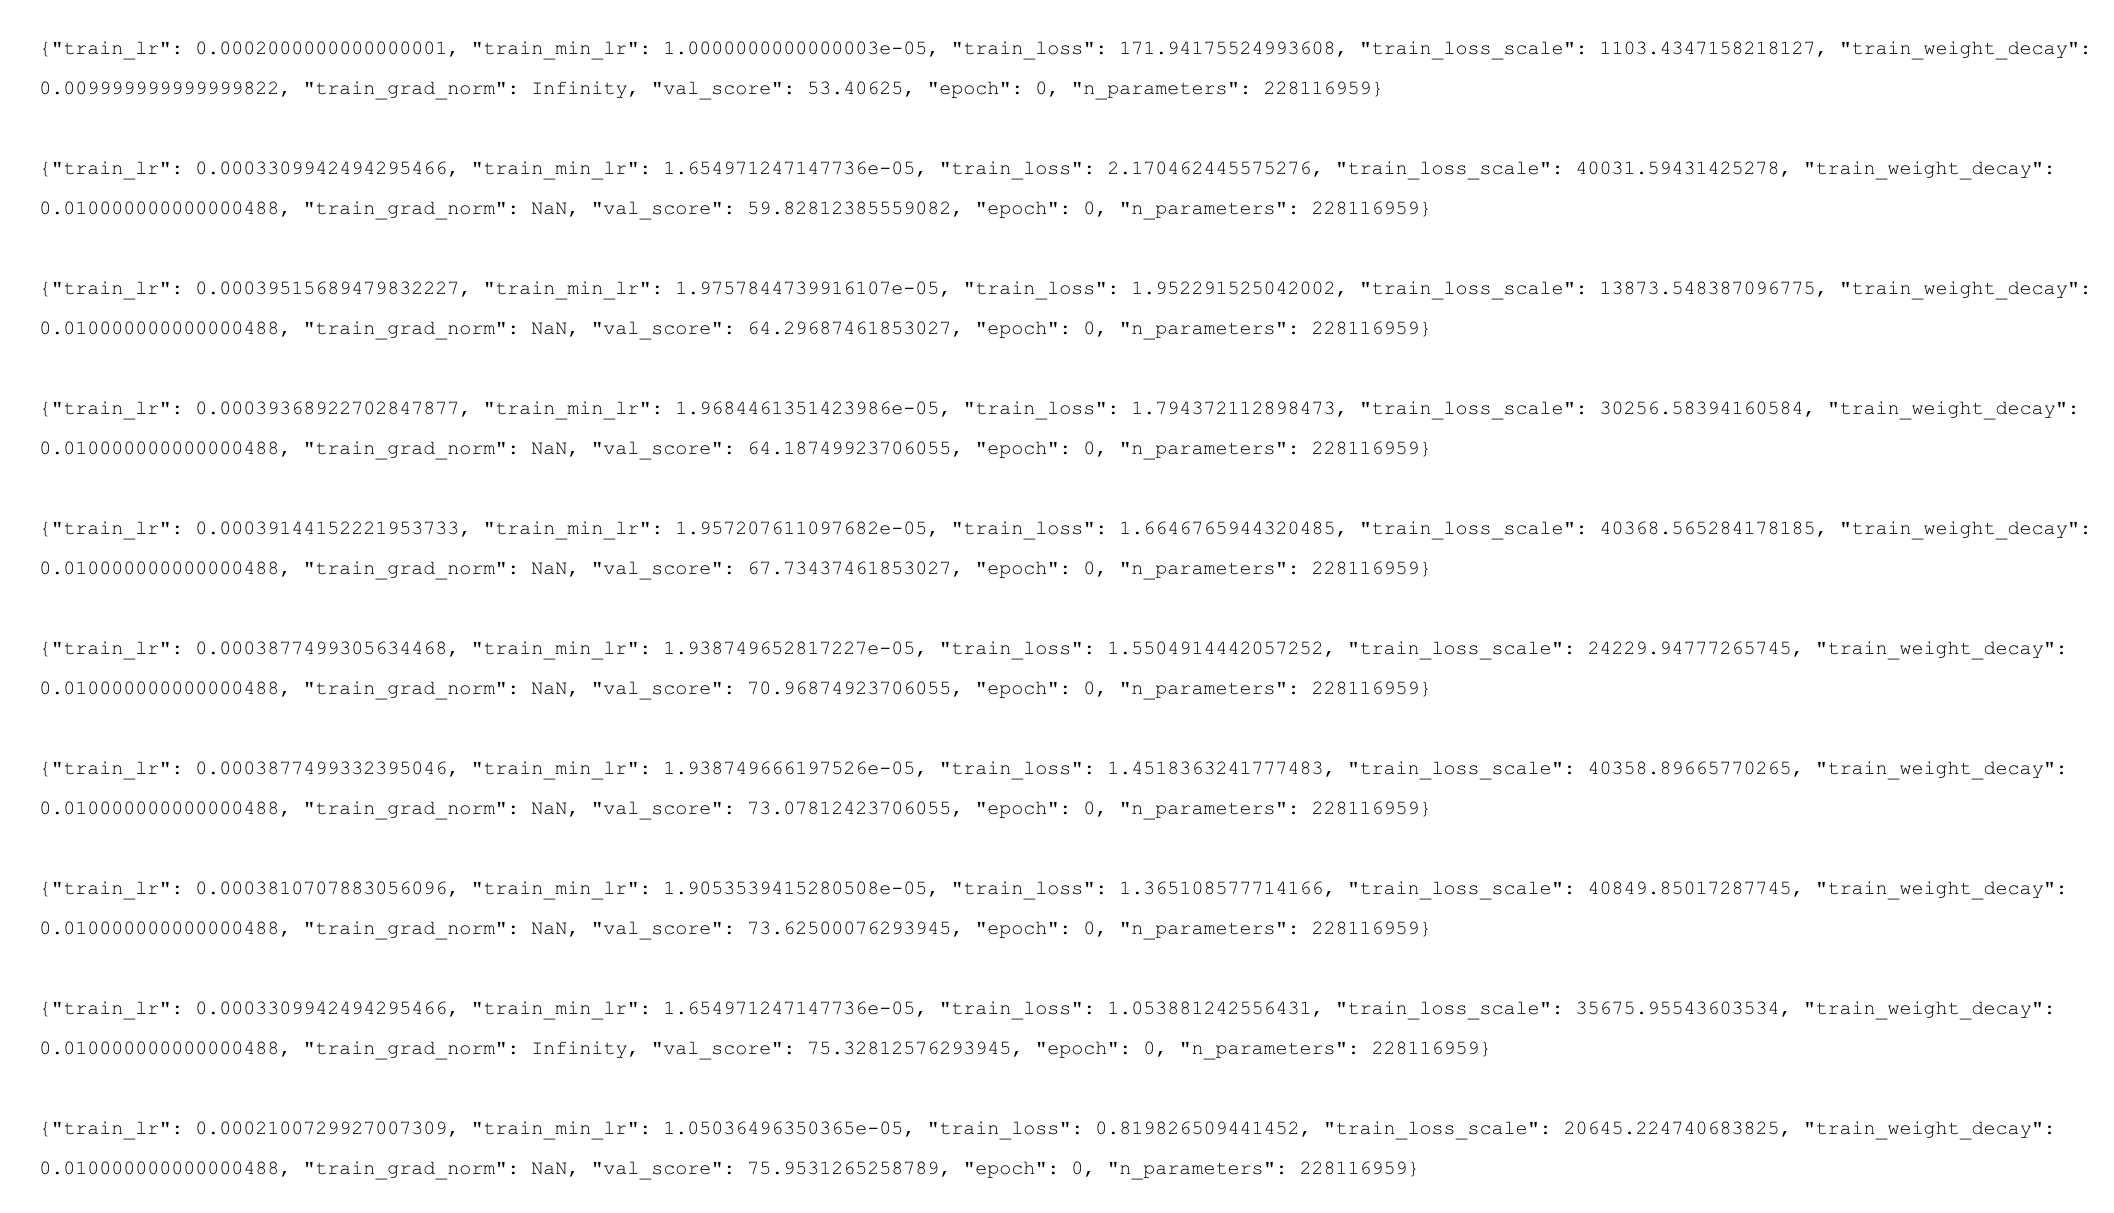

In [ ]:
# 처음에 학습할 때는 위에서 받은 모델의 zip파일을 그대로 사용하시면 됩니다.
# 코랩이 아닌 로컬에서 학습하시는 분들은 2번째 코드 쓰시지 마시고 그냥 이 코드를 쭉 진행시켜주시면 됩니다.

# !python run_beit3_finetuning.py \
#         --model beit3_base_patch16_384 \
#         --input_size 384 \
#         --task vqacustom \
#         --batch_size 256 \
#         --layer_decay 1.0 \
#         --lr 2e-5 \
#         --update_freq 1 \
#         --randaug \
#         --epochs 10 \
#         --warmup_epochs 1 \
#         --drop_path 0.15 \
#         --sentencepiece_model /content/drive/MyDrive/Dacon_multimodal/model_file/beit3.spm \
#         --finetune /content/drive/MyDrive/Dacon_multimodal/model_file/beit3_base_indomain_patch16_224.zip \
#         --data_path /content/ \
#         --output_dir /content/drive/MyDrive/Dacon_multimodal/finetuned_model_file/ \
#         --log_dir /content/drive/MyDrive/Dacon_multimodal/finetuned_model_file/log \
#         --weight_decay 0.01 \
#         --seed 42 \
#         --save_ckpt_freq 5 \
#         --task_head_lr_weight 20 \
#         --opt_betas 0.9 0.98 \
#         --checkpoint_activations

In [ ]:
# 그리고 여기 학습 부터는 위 코드로 1 epoch 실행한 결과인 checkpoint_model을 가져와 학습했습니다.
# epoch : [9, 8, 7, 6, 5, 4, 3, 2, 1]

!python run_beit3_finetuning.py \
        --model beit3_base_patch16_384 \
        --input_size 384 \
        --task vqacustom \
        --batch_size 128 \
        --layer_decay 1.0 \
        --lr 2e-5 \
        --update_freq 1 \
        --randaug \
        --epochs 9 \
        --warmup_epochs 0 \
        --drop_path 0.15 \
        --sentencepiece_model /content/drive/MyDrive/Dacon_multimodal/model_file/beit3.spm \
        --finetune /content/drive/MyDrive/Dacon_multimodal/finetuned_model_file/checkpoint-best.pth \
        --data_path /content/ \
        --output_dir /content/drive/MyDrive/Dacon_multimodal/finetuned_model_file/ \
        --log_dir /content/drive/MyDrive/Dacon_multimodal/finetuned_model_file/log \
        --weight_decay 0.01 \
        --seed 42 \
        --save_ckpt_freq 5 \
        --task_head_lr_weight 20 \
        --opt_betas 0.9 0.98 \
        --checkpoint_activations

In [ ]:
'''
이제 위에서 fine-tuning한 model로, test dataset 평가를 하면 됩니다. 평가 후 result는 output_dir에 저장됩니다.
저는 학습한 model 파일의 이름을 custom_model로 바꿔주었습니다.
'''

In [ ]:
!python run_beit3_finetuning.py \
        --model beit3_base_patch16_384 \
        --input_size 384 \
        --task vqacustom \
        --batch_size 128 \
        --sentencepiece_model /content/drive/MyDrive/Dacon_multimodal/model_file/beit3.spm \
        --finetune /content/drive/MyDrive/Dacon_multimodal/finetuned_model_file/custom_model.pth \
        --data_path /content/ \
        --output_dir /content/drive/MyDrive/Dacon_multimodal/finetuned_model_file/ \
        --eval

In [ ]:
'''
평가한 테스트 데이터셋의 형식이 json으로 되어있습니다. json의 question_id 양옆 1을 떼고, sample_submission을 반복 돌면서 채우도록 하겠습니다.
그리고 submission 파일을 구글드라이브에 저장해주면 끝입니다.
'''

In [ ]:
with open('/content/drive/MyDrive/Dacon_multimodal/finetuned_model_file/submit_vqacustom_test.json', "r") as json_file:
    datas = json.load(json_file)

final_submission = sample_submission.copy()

for data in datas:
    id = 'TEST_' + str(data['question_id'])[1:6]
    final_submission.loc[final_submission['ID'] == id, 'answer'] = data['answer']

final_submission.to_csv('/content/drive/MyDrive/Dacon_multimodal/submission.csv', index=False)

final_submission

,ID,answer
0,TEST_00000,no
1,TEST_00001,beach
2,TEST_00002,red
3,TEST_00003,white
4,TEST_00004,yes
...,...,...
40474,TEST_40474,phone
40475,TEST_40475,graffiti
40476,TEST_40476,air
40477,TEST_40477,blue
